# Model Explanation and Cross Validation

In [12]:
import pandas as pd
import numpy as np

#For plotting
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime

# Import the SimpleExpSmoothing object
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA

import random

As mentioned in the DataPreparation notebook, we focus our attention on predicting **6**-month horizon given **12** month datas of games we want to predict.

Note that different horizon or given data may change the accuracy or the best smoothing/metric for prediction.

### Load in the training data

In [13]:
train = pd.read_csv('Training_data.csv', index_col=0)
train_pure = pd.read_csv('Training_data_pure.csv', index_col=0)
test = pd.read_csv('Test_data.csv', index_col = 0)
test_pure = pd.read_csv('Test_data_pure.csv', index_col = 0)

Notice we also loaded in the test data. This is purely for examples and demonstration purpose. The test data is not used for any model building.

In [16]:
def nonsmooth_values(data):
    nonsmooth = []
    for i in range(len(data)):
        game_data = data.iloc[i]
        months = pd.to_datetime(game_data.index)
        game = pd.DataFrame({'Month':months,'Data': game_data.astype(float)}).sort_values(by=['Month'])
        temp = game['Data'][game['Data'].first_valid_index():game['Data'].last_valid_index()].values
        nonsmooth.append(temp)
    return nonsmooth

In [17]:
nonsmooth_test = nonsmooth_values(test_pure)
nonsmooth_train = nonsmooth_values(train_pure)

One may ask why our train test split only has X. This is because we want to use the same train test split for different smoothing methods so that we can compare the accuracy better. If one has chosen the method of smoothing, X will be the first 12 months of the smoothed data, and y will be the next 6 months of the smoothed data.

## Prediction Model

Here we build our prediction model.

First we define the metric and weight using l2 norm and Gaussian kernel.

In [18]:
def rootmse(a, b):
    return np.sqrt(np.sum((a-b)**2))

def Gauss_weight(a, b, epsilon = 20):
    return np.exp(-epsilon*rootmse(a,b)**2)

To compare the shape of 2 curves, we want to compute the scalar that makes 2 curves close together by scaling only.

In [19]:
def mini_scaler(a,b):
    return np.sum(a*b)/np.sum(a**2)

With the weight function and minimizing scalar defined above, we define the weight average function that acts as our prediction.

In the rest of the paragraph, target data refer to the 12-month input data that we want to predict the next 6 month on.

The model is done in the following steps:

1. **Smooth** out the training and target data with appropriate smoothing methods introduced later.

2. **Scale** the target data as a reference point for comparison with training data.

3. For each smoothed training data, scale it according to the scaled target data and compute its relative **weight** according to the distance from the scaled target data.

4. Scale each of the corresponding (unsmoothed) training data, add them up using a **weighted sum**, while omitting the ones with their weights less than a certain threshold.

5. Scale the resulting weighted sum according to the original target data. This is our **prediction**.


In [47]:
def wt_avg(game, smooth_game, data, smooth_data, metric = Gauss_weight, epsilon = 20, threshold=0.8, horizon = 6):
    length = len(game)
    smooth_length = len(smooth_game)
    if np.max(np.abs(smooth_game))!=0:
        smooth_game_scaled = smooth_game / rootmse(smooth_game,0)
    else:
        smooth_game_scaled = smooth_game
    pred = np.zeros(length+horizon)
    close_index = np.zeros((len(data),2))
    j=0
    for i in range(len(data)):
        temp = data[i]
        smooth_temp = smooth_data[i]
        if len(temp)>=length+horizon:
            if np.max(np.abs(temp[:length]))!=0:
                temp_scaled = temp * mini_scaler(temp[:length],game)
            else: temp_scaled = temp
            if np.max(np.abs(smooth_temp[:smooth_length]))!=0:
                smooth_temp_scaled = smooth_temp * mini_scaler(smooth_temp[:smooth_length],smooth_game_scaled)
            else: smooth_temp_scaled = smooth_temp
            weight=metric(smooth_game_scaled,smooth_temp_scaled[:smooth_length], epsilon = epsilon)
            if weight >= threshold:
                pred = pred + weight * temp_scaled[:length+horizon]
                close_index[j]=[i,weight]
                j=j+1
    if np.max(np.abs(pred[:length])) !=0:
        pred = pred * mini_scaler(pred[:length],game)
    else:
        pred = np.ones(length + horizon) * smooth_game[-1]
    close_index = close_index[:j]
    close_index = close_index[np.argsort(close_index[:, 1])][::-1]
    return pred, close_index

Now we define the error measurement we want to minimise. Since we used l2 norm (rootmse) in the above calculation, we also use that here.

In order to calculate average 'percentage error' over the test set, we normalize the error by the l2 norm of the test data. Equivalently, we are normalizing the l2 norm of the predicted values and the test data before computing the error.

Here percentage error refers to the error relative to the l2 norm of test data

In [21]:
def Get_error(train, smooth_train, test, smooth_test, threshold = 0.8, epsilon = 20):
    error = 0
    for i in range(len(test)):
        [pred, close_index] = wt_avg(test[i][:12], smooth_test[i][:12], train, smooth_train, threshold = threshold, epsilon = epsilon, horizon = 6)
        error = error + rootmse(pred[12:],test[i][12:18]) / rootmse(test[i][12:18],0)
    error = error / len(test)
    return error

## Prediction Model using Exponential Smoothing

In [22]:
# Getting the smoothed curve for each game
# Ordered in increasing time order.

def smooth_values(data, smoothing_level=.5):
    smooth_timedata = []
    for i in range(len(data)):
        game_data = data.iloc[i]
        months = pd.to_datetime(game_data.index)
        game = pd.DataFrame({'Month':months,'Data': game_data.astype(float)}).sort_values(by=['Month'])
        temp = game['Data'][game['Data'].first_valid_index():game['Data'].last_valid_index()]
    
        # Fit exponential smoothing
        ses = SimpleExpSmoothing(temp.values)
        fit = ses.fit(smoothing_level=smoothing_level, optimized=False)

        smooth_timedata.append(fit.fittedvalues)
        
    return smooth_timedata

Getting the smoothed curves.

In [23]:
alpha = .6
ExpSmooth_train = smooth_values(train_pure, smoothing_level = alpha)
ExpSmooth_test = smooth_values(test_pure, smoothing_level = alpha)

C:\Users\Joseph Leung\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


A Prediction Example:

In [51]:
# Randomly pick a game from test set and use its first 18 month data
ind = 2
real_game = nonsmooth_test[ind][:18]
game = nonsmooth_test[ind][:12]
smooth_real_game = ExpSmooth_test[ind][:18]
smooth_game = smooth_real_game[:12]
[pred,close_index] = wt_avg(game, smooth_game, nonsmooth_train, ExpSmooth_train, horizon = 6, epsilon = 20, threshold = 0.8)

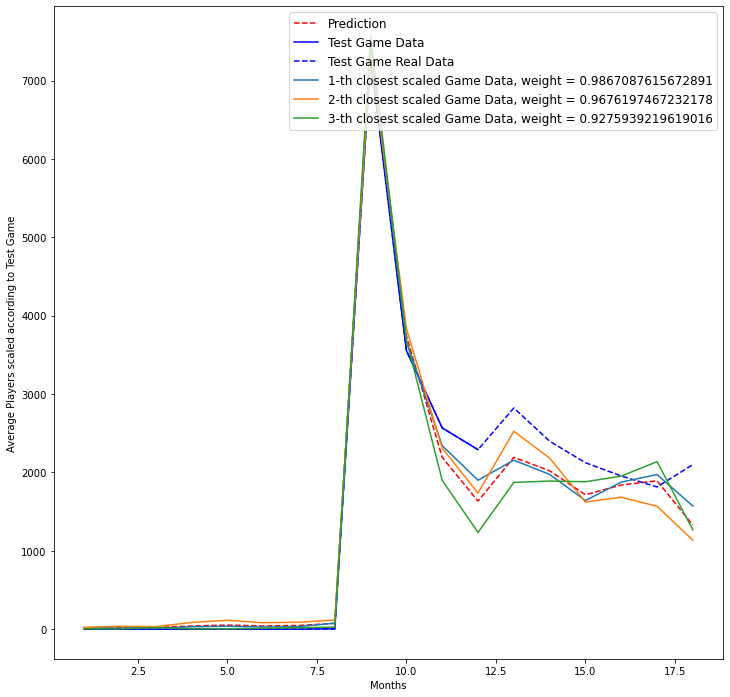

In [52]:
plt.figure(figsize=(12,12))
plt.plot(range(1,len(game)+7), pred, 'r--', label = 'Prediction')
plt.plot(range(1,len(game)+1), game, 'b', label = 'Test Game Data')
plt.plot(range(1,len(game)+7), real_game, 'b--', label = 'Test Game Real Data')

if len(close_index)>=3:
    test_range = range(3)
    for i in test_range:
        close_game = nonsmooth_train[int(close_index[i][0])][:len(game)+6]
        scaled_close_game = close_game * mini_scaler(close_game[:len(game)],game)
        plt.plot(range(1,len(game)+7), scaled_close_game, label = str(i+1)+'-th closest scaled Game Data, weight = ' + str(close_index[i][1]))

plt.legend(fontsize=12)
plt.xlabel('Months')
plt.ylabel('Average Players scaled according to Test Game')
plt.show()

### Cross Validation

CV to get the best parameters for the model.

In [34]:
# CV 5 fold split
from sklearn.model_selection import KFold
kfold = KFold(n_splits = 5, shuffle = True, random_state = 440)

In [1]:
def Get_best_eps_thres(data, smooth_data):
    error = 50
    best_eps = 5000
    best_thres = 0.5
    for epsilon in np.arange(15,35,5):
        print(epsilon)
        for threshold in np.arange(0.5,0.85,0.1):
            print(threshold)
            temp_error = 0
            for train_index, test_index in kfold.split(data):
                train = [data[index] for index in train_index]
                test = [data[index] for index in test_index]
                smooth_train = [smooth_data[index] for index in train_index]
                smooth_test = [smooth_data[index] for index in test_index]
                temp_error = temp_error + Get_error(train, smooth_train, test, smooth_test, threshold = threshold, epsilon = epsilon)
        if temp_error < error:
                error = temp_error
                best_eps = epsilon
                best_thres = threshold
    error = error / 5
    return best_eps, best_thres, error

In [41]:
[best_eps, best_thres, error] = Get_best_eps_thres(nonsmooth_train, ExpSmooth_train)

15
0.5
0.6
0.7
0.7999999999999999
20
0.5
0.6
0.7
0.7999999999999999
25
0.5
0.6
0.7
0.7999999999999999
30
0.5
0.6
0.7
0.7999999999999999


In [39]:
print('For alpha = .6, optimal: epsilon = ' + str(best_eps) + ', optimal threshold = ' + str(best_thres) + ', percentage error = ' + str(error) + '.')

After checking CV with smoothing level = 0.2, 0.4, 0.6, 0.8, 1, 0.6 yields the least percentage error of around 0.838 * 100% = 83.8%, with the best epsilon being 20, and best threshold 0.8.

Note that smoothing level = 1 means we do not smooth the curve. This means CV confirms that appropriate smoothing is beneficial.

## Prediction Model using Moving Average Smoothing

In [42]:
#Moving Average smoothing:

def mov_avg(data, window=3):
    smooth_timedata = []
    for i in range(len(data)):
        game_data = data.iloc[i]
        months = pd.to_datetime(game_data.index)
        game = pd.DataFrame({'Month':months,'Data': game_data.astype(float)}).sort_values(by=['Month'])
        temp = game['Data'][game['Data'].first_valid_index():game['Data'].last_valid_index()]
    
        # Fit moving average smoothing
        smooth = np.zeros(len(temp)-window+1)    
        for i in range(len(temp)-window+1):
            current_window = temp[i:i+window]
            smooth[i]=current_window.sum()/window
        smooth_timedata.append(smooth)
    return smooth_timedata

Getting the smoothed curves.

In [43]:
window = 3
MovAvg_train = mov_avg(train_pure, window = window)
MovAvg_test = mov_avg(test_pure, window = window)

A Prediction Example

In [66]:
# Randomly pick a game from test set and use its first 18 month data
ind = 13
real_game = nonsmooth_test[ind][:18]
game = nonsmooth_test[ind][:12]
MovAvg_real_game = MovAvg_test[ind][:18-window+1]
MovAvg_game = smooth_real_game[:12-window+1]
[pred,close_index] = wt_avg(game, MovAvg_game, nonsmooth_train, MovAvg_train, horizon = 6, epsilon = 20, threshold = 0.5)

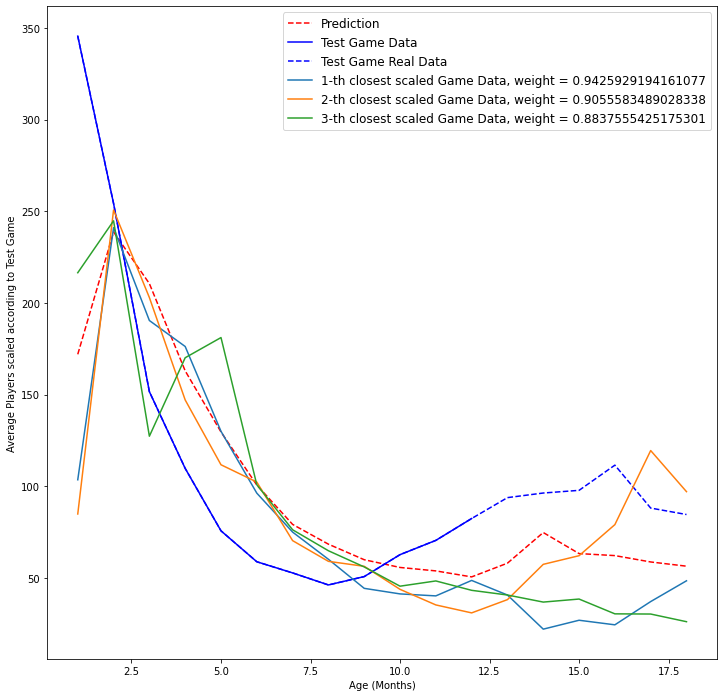

In [67]:
plt.figure(figsize=(12,12))
plt.plot(range(1,len(game)+7), pred, 'r--', label = 'Prediction')
plt.plot(range(1,len(game)+1), game, 'b', label = 'Test Game Data')
plt.plot(range(1,len(game)+7), real_game, 'b--', label = 'Test Game Real Data')

test_range = range(3)
for i in test_range:
    close_game = nonsmooth_train[int(close_index[i][0])][:len(game)+6]
    scaled_close_game = close_game * mini_scaler(close_game[:len(game)],game)
    plt.plot(range(1,len(game)+7), scaled_close_game, label = str(i+1)+'-th closest scaled Game Data, weight = ' + str(close_index[i][1]))

plt.legend(fontsize=12)
plt.xlabel('Age (Months)')
plt.ylabel('Average Players scaled according to Test Game')
plt.show()

### Cross Validation

We have to slightly adjust the get_error function since our smooth data from 12 months only have 12-window+1 data points.

In [75]:
def Get_MovAvg_error(train, smooth_train, test, smooth_test, threshold = 0.4, epsilon = 20, window = 3):
    error = 0
    for i in range(len(test)):
        [pred, close_index] = wt_avg(test[i][:12], smooth_test[i][:12-window+1], train, smooth_train, threshold = threshold, epsilon = epsilon, horizon = 6)
        error = error + rootmse(pred[12:],test[i][12:18]) / rootmse(test[i][12:18],0)
    error = error / len(test)
    return error

In [81]:
def Get_MovAvg_best_eps_thres(data, smooth_data):
    error = 50
    best_eps = 5000
    best_thres = 0.5
    for epsilon in np.arange(15,35,5):
        print(epsilon)
        for threshold in np.arange(0.5,0.85,0.1):
            print(threshold)
            temp_error = 0
            for train_index, test_index in kfold.split(data):
                train = [data[index] for index in train_index]
                test = [data[index] for index in test_index]
                smooth_train = [smooth_data[index] for index in train_index]
                smooth_test = [smooth_data[index] for index in test_index]
                temp_error = temp_error + Get_MovAvg_error(train, smooth_train, test, smooth_test, threshold = threshold, epsilon = epsilon)
        if temp_error < error:
                error = temp_error
                best_eps = epsilon
                best_thres = threshold
    error = error / 5
    return best_eps, best_thres, error

In [78]:
[best_eps, best_thres, error] = Get_MovAvg_best_eps_thres(nonsmooth_train, MovAvg_train)

20
0.8


In [80]:
print('For window = 3, optimal: epsilon = ' + str(best_eps) + ', optimal threshold = ' + str(best_thres) + ', percentage error = ' + str(error) + '.')

For window = 3, optimal: epsilon = 50, optimal threshold = 0.5, percentage error = 10.0.


Error is much worse than Exponential Smoothing